In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import os
import glob

def create_sequences(data, features, target, sequence_length=48, stride=1):
    # Scale the data
    scaler_X = RobustScaler()
    scaler_y = RobustScaler()
    X = scaler_X.fit_transform(data[features])
    y = scaler_y.fit_transform(data[[target]])

    # Create sequences
    X_sequences = []
    y_sequences = []
    for i in range(0, len(data) - sequence_length, stride):
        X_sequences.append(X[i:(i + sequence_length)])
        y_sequences.append(y[i + sequence_length])

    return np.array(X_sequences), np.array(y_sequences), scaler_X, scaler_y

def process_single_fid(file_path, features, target, sequence_length=48, stride=1):
    # Read the CSV file
    df = pd.read_csv(file_path)
    df = df.dropna()

    # Convert monitoring column to numeric
    df[target] = pd.to_numeric(df[target], errors='coerce')

    # Handle missing values and outliers
    df[features] = df[features].ffill().bfill()

    # Convert all columns to numeric
    df = df.apply(pd.to_numeric, errors='coerce')

    # Create sequences
    X_sequences, y_sequences, scaler_X, scaler_y = create_sequences(
        df, features, target, sequence_length, stride
    )

    # Split the data for this FID
    if len(X_sequences) > 0:
        X_train, X_test, y_train, y_test = train_test_split(
            X_sequences, y_sequences, test_size=0.2, random_state=42
        )
        return {
            'X_train': X_train,
            'X_test': X_test,
            'y_train': y_train,
            'y_test': y_test,
            'scaler_X': scaler_X,
            'scaler_y': scaler_y,
            'fid': os.path.basename(file_path)
        }
    return None

def process_all_fids(directory_path):
    # Define features and target
    features = ['RH_merra', 'aod', 'bc', 'cmaqPM', 'dustpm', 'rad_merra',
                'rain_merra', 'temperature', 'wind_merra']
    target = 'monitoring'

    # Get all FID CSV files
    csv_files = glob.glob(os.path.join(directory_path, "FID_*.csv"))

    # Store results for each FID
    all_fid_data = {}

    # Combined training and test data
    X_train_combined = []
    y_train_combined = []
    X_test_combined = []
    y_test_combined = []

    # Process each FID file
    for csv_file in csv_files:
        try:
            result = process_single_fid(csv_file, features, target)
            if result is not None:
                fid = result['fid']
                all_fid_data[fid] = result

                # Add to combined training data
                X_train_combined.append(result['X_train'])
                y_train_combined.append(result['y_train'])

                # Add to combined test data
                X_test_combined.append(result['X_test'])
                y_test_combined.append(result['y_test'])

                #print(f"Successfully processed: {fid}")
        except Exception as e:
            print(f"Error processing {csv_file}: {str(e)}")

    # Combine all training data
    X_train_combined = np.concatenate(X_train_combined, axis=0)
    y_train_combined = np.concatenate(y_train_combined, axis=0)

    # Combine all test data
    X_test_combined = np.concatenate(X_test_combined, axis=0)
    y_test_combined = np.concatenate(y_test_combined, axis=0)

    return all_fid_data, X_train_combined, y_train_combined, X_test_combined, y_test_combined

# Usage
directory_path = "Dataset/"
all_fid_data, X_train, y_train, X_test_c, y_test_c = process_all_fids(directory_path)

Error processing Dataset\FID_FID.csv: Found array with 0 sample(s) (shape=(0, 9)) while a minimum of 1 is required by RobustScaler.


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Dense, Input, Conv1D, BatchNormalization,
                                   Activation, Add, GlobalAveragePooling1D)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Define ResNet blocks
def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    x = Conv1D(filters, kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv1D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)

    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv1D(filters, 1, strides=stride, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def create_resnet_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, 7, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # ResNet blocks
    x = residual_block(x, 64)
    x = residual_block(x, 64)
    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 128)
    x = residual_block(x, 256, stride=2)
    x = residual_block(x, 256)

    x = GlobalAveragePooling1D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(1)(x)  # Single output for regression

    model = Model(inputs, outputs)
    return model

In [5]:
# Create and compile ResNet model
model = create_resnet_model((X_train.shape[1], X_train.shape[2]))
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mae')

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=10,
    min_lr=0.0001
)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/15
15887/15887 ━━━━━━━━━━━━━━━━━━━━ 400s 25ms/step - loss: 0.5735 - val_loss: 0.6051 - learning_rate: 0.0010
Epoch 2/15
15887/15887 ━━━━━━━━━━━━━━━━━━━━ 410s 26ms/step - loss: 0.4278 - val_loss: 0.5340 - learning_rate: 0.0010
Epoch 3/15
15887/15887 ━━━━━━━━━━━━━━━━━━━━ 415s 26ms/step - loss: 0.3729 - val_loss: 0.5113 - learning_rate: 0.0010
Epoch 4/15
15887/15887 ━━━━━━━━━━━━━━━━━━━━ 420s 26ms/step - loss: 0.3385 - val_loss: 0.4988 - learning_rate: 0.0010
Epoch 5/15
15887/15887 ━━━━━━━━━━━━━━━━━━━━ 418s 26ms/step - loss: 0.3145 - val_loss: 0.4834 - learning_rate: 0.0010
Epoch 6/15
15887/15887 ━━━━━━━━━━━━━━━━━━━━ 436s 27ms/step - loss: 0.2918 - val_loss: 0.4743 - learning_rate: 0.0010
Epoch 7/15
15887/15887 ━━━━━━━━━━━━━━━━━━━━ 448s 28ms/step - loss: 0.2777 - val_loss: 0.4603 - learning_rate: 0.0010
Epoch 8/15
15887/15887 ━━━━━━━━━━━━━━━━━━━━ 455s 29ms/step - loss: 0.2648 - val_loss: 0.4594 - learning_rate: 0.0010
Epoch 9/15
15887/15887 ━━━━━━━━━━━━━━━━━━━━ 460s 29ms/step - los

In [7]:
# Model Saving
from tensorflow import keras
model.save('ResNet.keras')

In [13]:
# Model Loading
from tensorflow.keras.models import load_model
res = load_model('ResNet.keras')
res.compile(optimizer='adam', loss='mae')

5045/5045 ━━━━━━━━━━━━━━━━━━━━ 66s 13ms/step

Metrics on Clean Test Data:
MAE: 2.7633
RMSE: 6.6164
R2: -0.0005


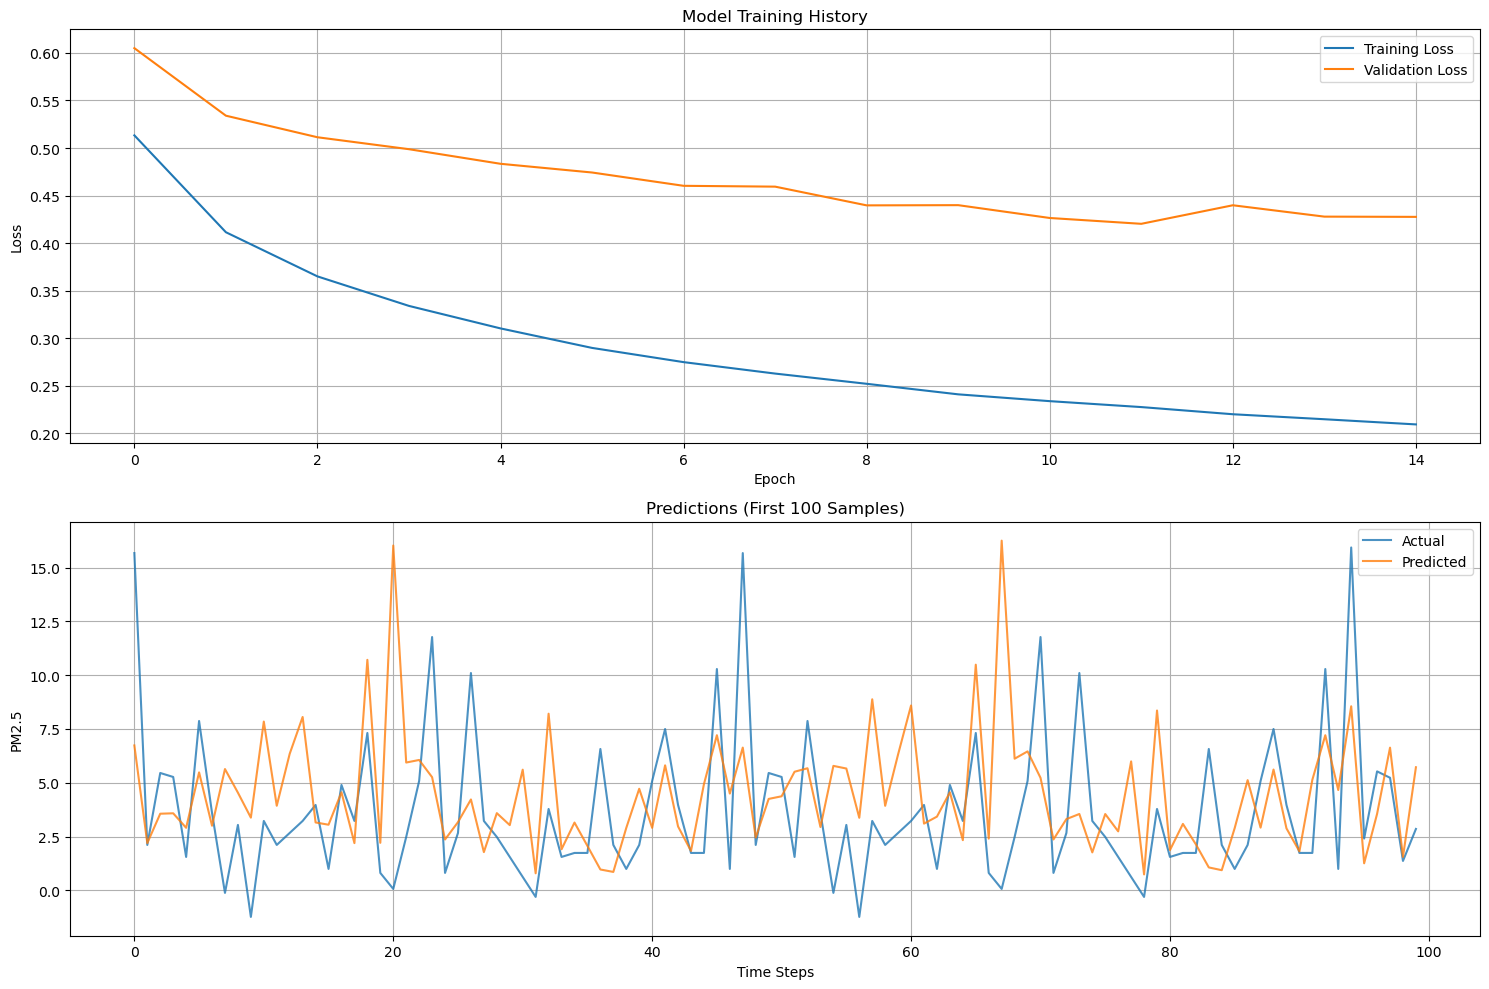

In [15]:
# First, let's create a combined scaler for all the data
def get_combined_scaler(all_fid_data, target='monitoring'):
    # Combine all data for fitting the scaler
    all_target_data = []
    for fid_data in all_fid_data.values():
        # Get the original data using the individual scaler
        y_test_orig = fid_data['scaler_y'].inverse_transform(fid_data['y_test'])
        y_train_orig = fid_data['scaler_y'].inverse_transform(fid_data['y_train'])
        all_target_data.extend(y_test_orig)
        all_target_data.extend(y_train_orig)

    # Create and fit a new scaler on all data
    combined_scaler = RobustScaler()
    combined_scaler.fit(np.array(all_target_data).reshape(-1, 1))

    return combined_scaler

# Get the combined scaler
combined_scaler = get_combined_scaler(all_fid_data)

# Now evaluate on clean test data
y_pred_clean = res.predict(X_test_c)
y_test_orig = combined_scaler.inverse_transform(y_test_c)
y_pred_clean_orig = combined_scaler.inverse_transform(y_pred_clean)

# Calculate metrics
metrics_clean = {
    'MAE': mean_absolute_error(y_test_orig, y_pred_clean_orig),
    'RMSE': np.sqrt(mean_squared_error(y_test_orig, y_pred_clean_orig)),
    'R2': r2_score(y_test_orig, y_pred_clean_orig)
}

# Print results
print("\nMetrics on Clean Test Data:")
for metric, value in metrics_clean.items():
    print(f"{metric}: {value:.4f}")

# Visualize results
plt.figure(figsize=(15, 10))

# Plot training history
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot predictions
plt.subplot(2, 1, 2)
plt.plot(y_test_orig[:100], label='Actual', alpha=0.8)
plt.plot(y_pred_clean_orig[:100], label='Predicted', alpha=0.8)
plt.title('Predictions (First 100 Samples)')
plt.xlabel('Time Steps')
plt.ylabel('PM2.5')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:

# Test on each FID separately
results = {}
for fid, data in all_fid_data.items():
    # Predict on test data for this FID
    predictions = model.predict(data['X_test'])

    # Inverse transform predictions and actual values
    predictions_original = data['scaler_y'].inverse_transform(predictions)
    y_test_original = data['scaler_y'].inverse_transform(data['y_test'])

    # Calculate metrics for this FID
    mse = np.mean((predictions_original - y_test_original) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(predictions_original - y_test_original))

    results[fid] = {
        'mse': mse,
        'rmse': rmse,
        'mae': mae
    }

    print(f"\nResults for {fid}:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")

# Save results if needed
results_df = pd.DataFrame.from_dict(results, orient='index')

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step

Results for FID_0.csv:
MSE: 4.4158
RMSE: 2.1014
MAE: 1.4929
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step

Results for FID_1.csv:
MSE: 4.7890
RMSE: 2.1884
MAE: 1.5736
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step

Results for FID_1001.csv:
MSE: 3.9750
RMSE: 1.9937
MAE: 1.4220
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step

Results for FID_1002.csv:
MSE: 3.9002
RMSE: 1.9749
MAE: 1.4638
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step

Results for FID_1003.csv:
MSE: 3.9002
RMSE: 1.9749
MAE: 1.4638
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

Results for FID_1004.csv:
MSE: 5.6562
RMSE: 2.3783
MAE: 1.6823
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step

Results for FID_1005.csv:
MSE: 2.5595
RMSE: 1.5998
MAE: 0.8758
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

Results for FID_1006.csv:
MSE: 2.6869
RMSE: 1.6392
MAE: 0.9427
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step

Results for FID_1007.csv:
MSE: 2.6869
RMSE: 1.6392
MAE: 0.9427
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

Results for FID_1008.csv:
MSE: 2.9190
RMSE: 1.7

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


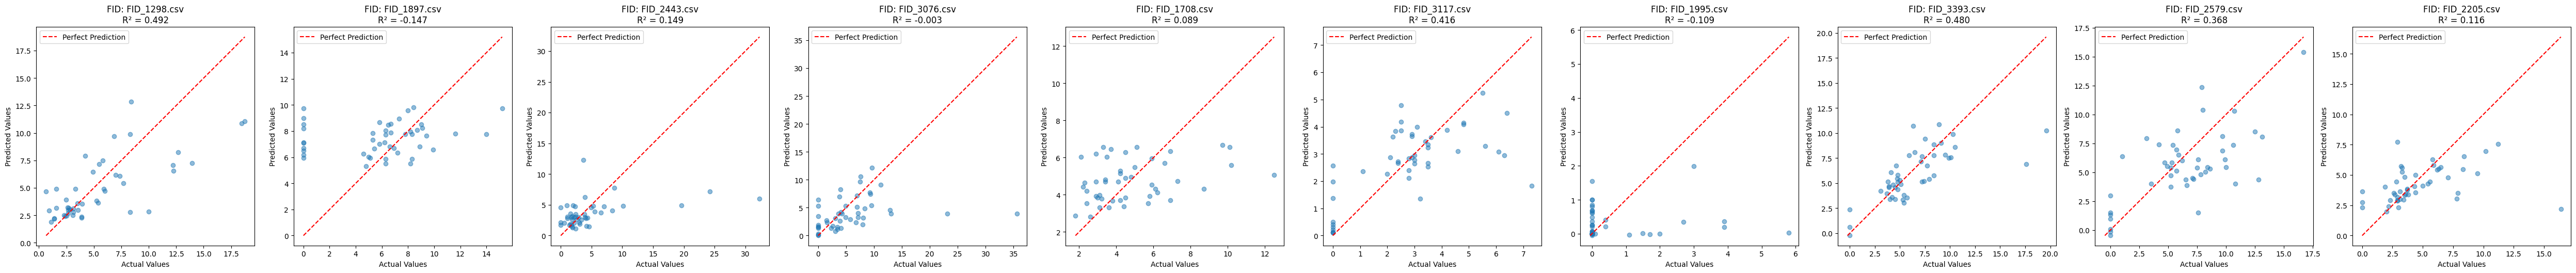

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import numpy as np

def plot_fid_predictions(all_fid_data, model, num_fids=3, figsize=(50, 15)):
    # Select a subset of FIDs to plot
    fids_to_plot = list(all_fid_data.keys())[:num_fids]

    # Create subplots
    fig, axes = plt.subplots(1, num_fids, figsize=figsize)

    for idx, fid in enumerate(fids_to_plot):
        data = all_fid_data[fid]

        # Get predictions
        predictions = model.predict(data['X_test'])

        # Inverse transform
        predictions_original = data['scaler_y'].inverse_transform(predictions)
        y_test_original = data['scaler_y'].inverse_transform(data['y_test'])

        # Calculate R² score
        r2 = r2_score(y_test_original, predictions_original)

        # Create scatter plot
        axes[idx].scatter(y_test_original, predictions_original, alpha=0.5)

        # Add perfect prediction line
        min_val = min(y_test_original.min(), predictions_original.min())
        max_val = max(y_test_original.max(), predictions_original.max())
        axes[idx].plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')

        # Add labels and title
        axes[idx].set_xlabel('Actual Values')
        axes[idx].set_ylabel('Predicted Values')
        axes[idx].set_title(f'FID: {fid}\nR² = {r2:.3f}')
        axes[idx].legend()

        # Make plot square
        axes[idx].set_aspect('equal', adjustable='box')

    plt.tight_layout()
    plt.show()

# Usage
plot_fid_predictions(all_fid_data, model, num_fids=10)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


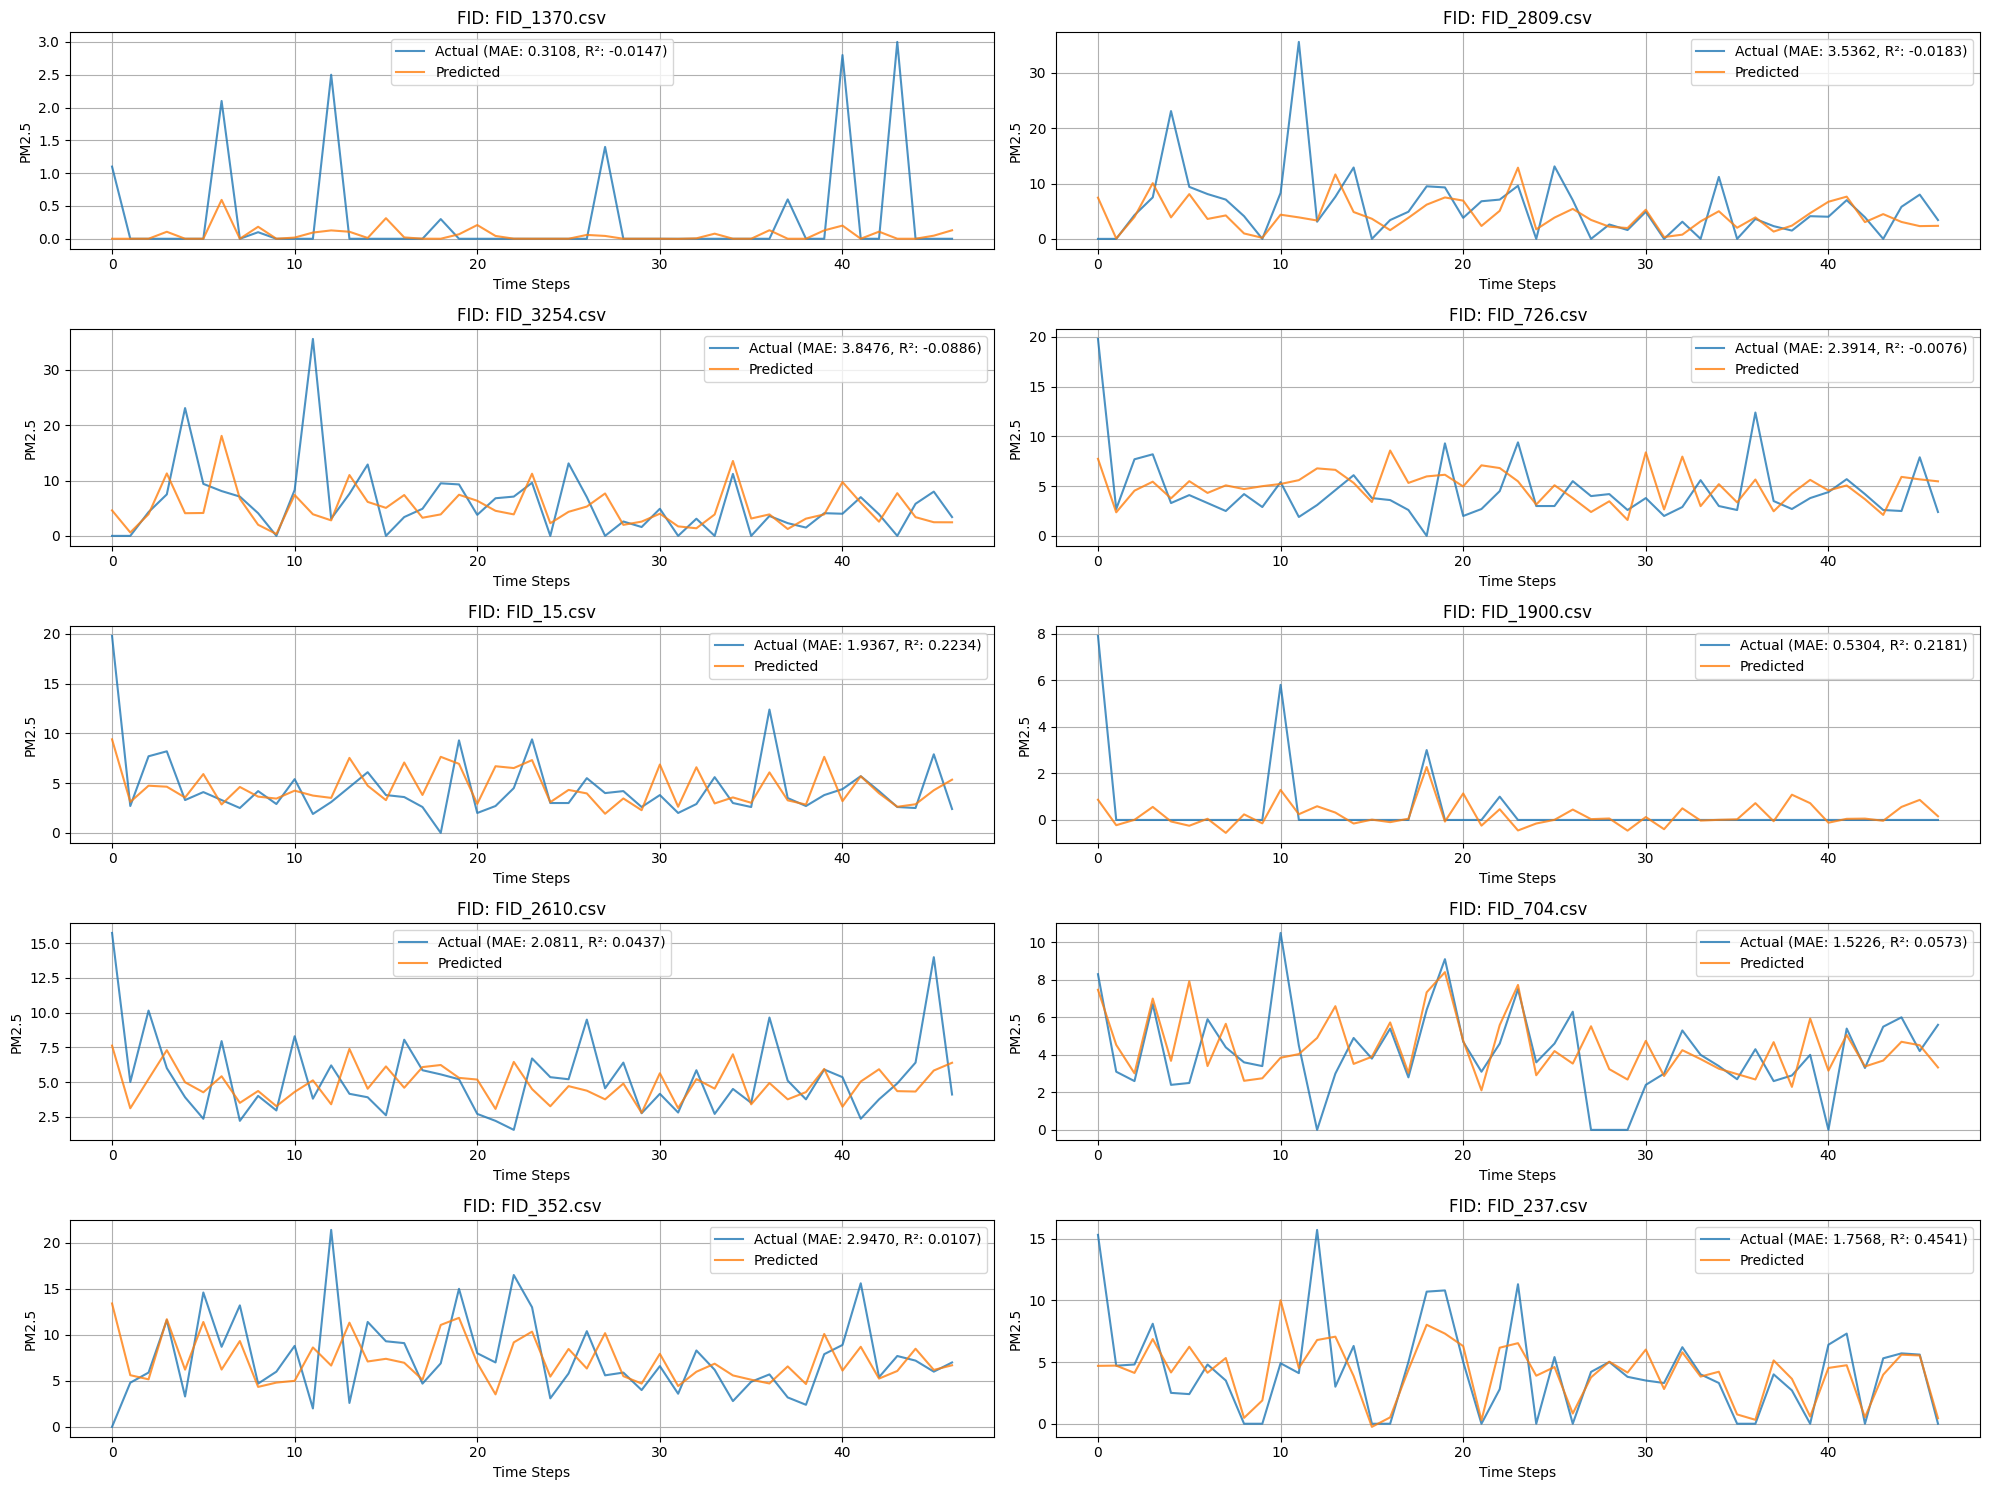


Metrics for each FID:
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

FID FID_1370.csv:
MAE: 0.3108
R²: -0.0147
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

FID FID_2809.csv:
MAE: 3.5362
R²: -0.0183
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

FID FID_3254.csv:
MAE: 3.8476
R²: -0.0886
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

FID FID_726.csv:
MAE: 2.3914
R²: -0.0076
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

FID FID_15.csv:
MAE: 1.9367
R²: 0.2234
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

FID FID_1900.csv:
MAE: 0.5304
R²: 0.2181
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

FID FID_2610.csv:
MAE: 2.0811
R²: 0.0437
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

FID FID_704.csv:
MAE: 1.5226
R²: 0.0573
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

FID FID_352.csv:
MAE: 2.9470
R²: 0.0107
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

FID FID_237.csv:
MAE: 1.7568
R²: 0.4541

Average metrics across selected FIDs:
Average MAE: 2.0861
Average R²: 0.0878


In [17]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import random

def plot_random_fid_predictions(all_fid_data, model, num_fids=10, num_samples=100, figsize=(20, 15)):
    # Randomly select FIDs
    selected_fids = random.sample(list(all_fid_data.keys()), min(num_fids, len(all_fid_data)))

    # Create subplots grid
    rows = (num_fids + 1) // 2  # Calculate number of rows needed
    fig, axes = plt.subplots(rows, 2, figsize=figsize)
    axes = axes.flatten()  # Flatten axes array for easier indexing

    for idx, fid in enumerate(selected_fids):
        data = all_fid_data[fid]

        # Get predictions
        predictions = model.predict(data['X_test'])

        # Inverse transform predictions and actual values
        predictions_original = data['scaler_y'].inverse_transform(predictions)
        y_test_original = data['scaler_y'].inverse_transform(data['y_test'])

        # Calculate metrics
        metrics = {
            'MAE': mean_absolute_error(y_test_original, predictions_original),
            'R2': r2_score(y_test_original, predictions_original)
        }

        # Plot predictions vs actual
        axes[idx].plot(y_test_original[:num_samples],
                      label=f'Actual (MAE: {metrics["MAE"]:.4f}, R²: {metrics["R2"]:.4f})',
                      alpha=0.8)
        axes[idx].plot(predictions_original[:num_samples],
                      label='Predicted',
                      alpha=0.8)
        axes[idx].set_title(f'FID: {fid}')
        axes[idx].set_xlabel('Time Steps')
        axes[idx].set_ylabel('PM2.5')
        axes[idx].legend()
        axes[idx].grid(True)

    # Remove any empty subplots
    for idx in range(len(selected_fids), len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()

    # Print average metrics across selected FIDs
    all_mae = []
    all_r2 = []

    print("\nMetrics for each FID:")
    for fid in selected_fids:
        data = all_fid_data[fid]
        predictions = model.predict(data['X_test'])
        predictions_original = data['scaler_y'].inverse_transform(predictions)
        y_test_original = data['scaler_y'].inverse_transform(data['y_test'])

        mae = mean_absolute_error(y_test_original, predictions_original)
        r2 = r2_score(y_test_original, predictions_original)

        all_mae.append(mae)
        all_r2.append(r2)

        print(f"\nFID {fid}:")
        print(f"MAE: {mae:.4f}")
        print(f"R²: {r2:.4f}")

    print("\nAverage metrics across selected FIDs:")
    print(f"Average MAE: {np.mean(all_mae):.4f}")
    print(f"Average R²: {np.mean(all_r2):.4f}")

# Usage
plot_random_fid_predictions(all_fid_data, model, num_fids=10, num_samples=100)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


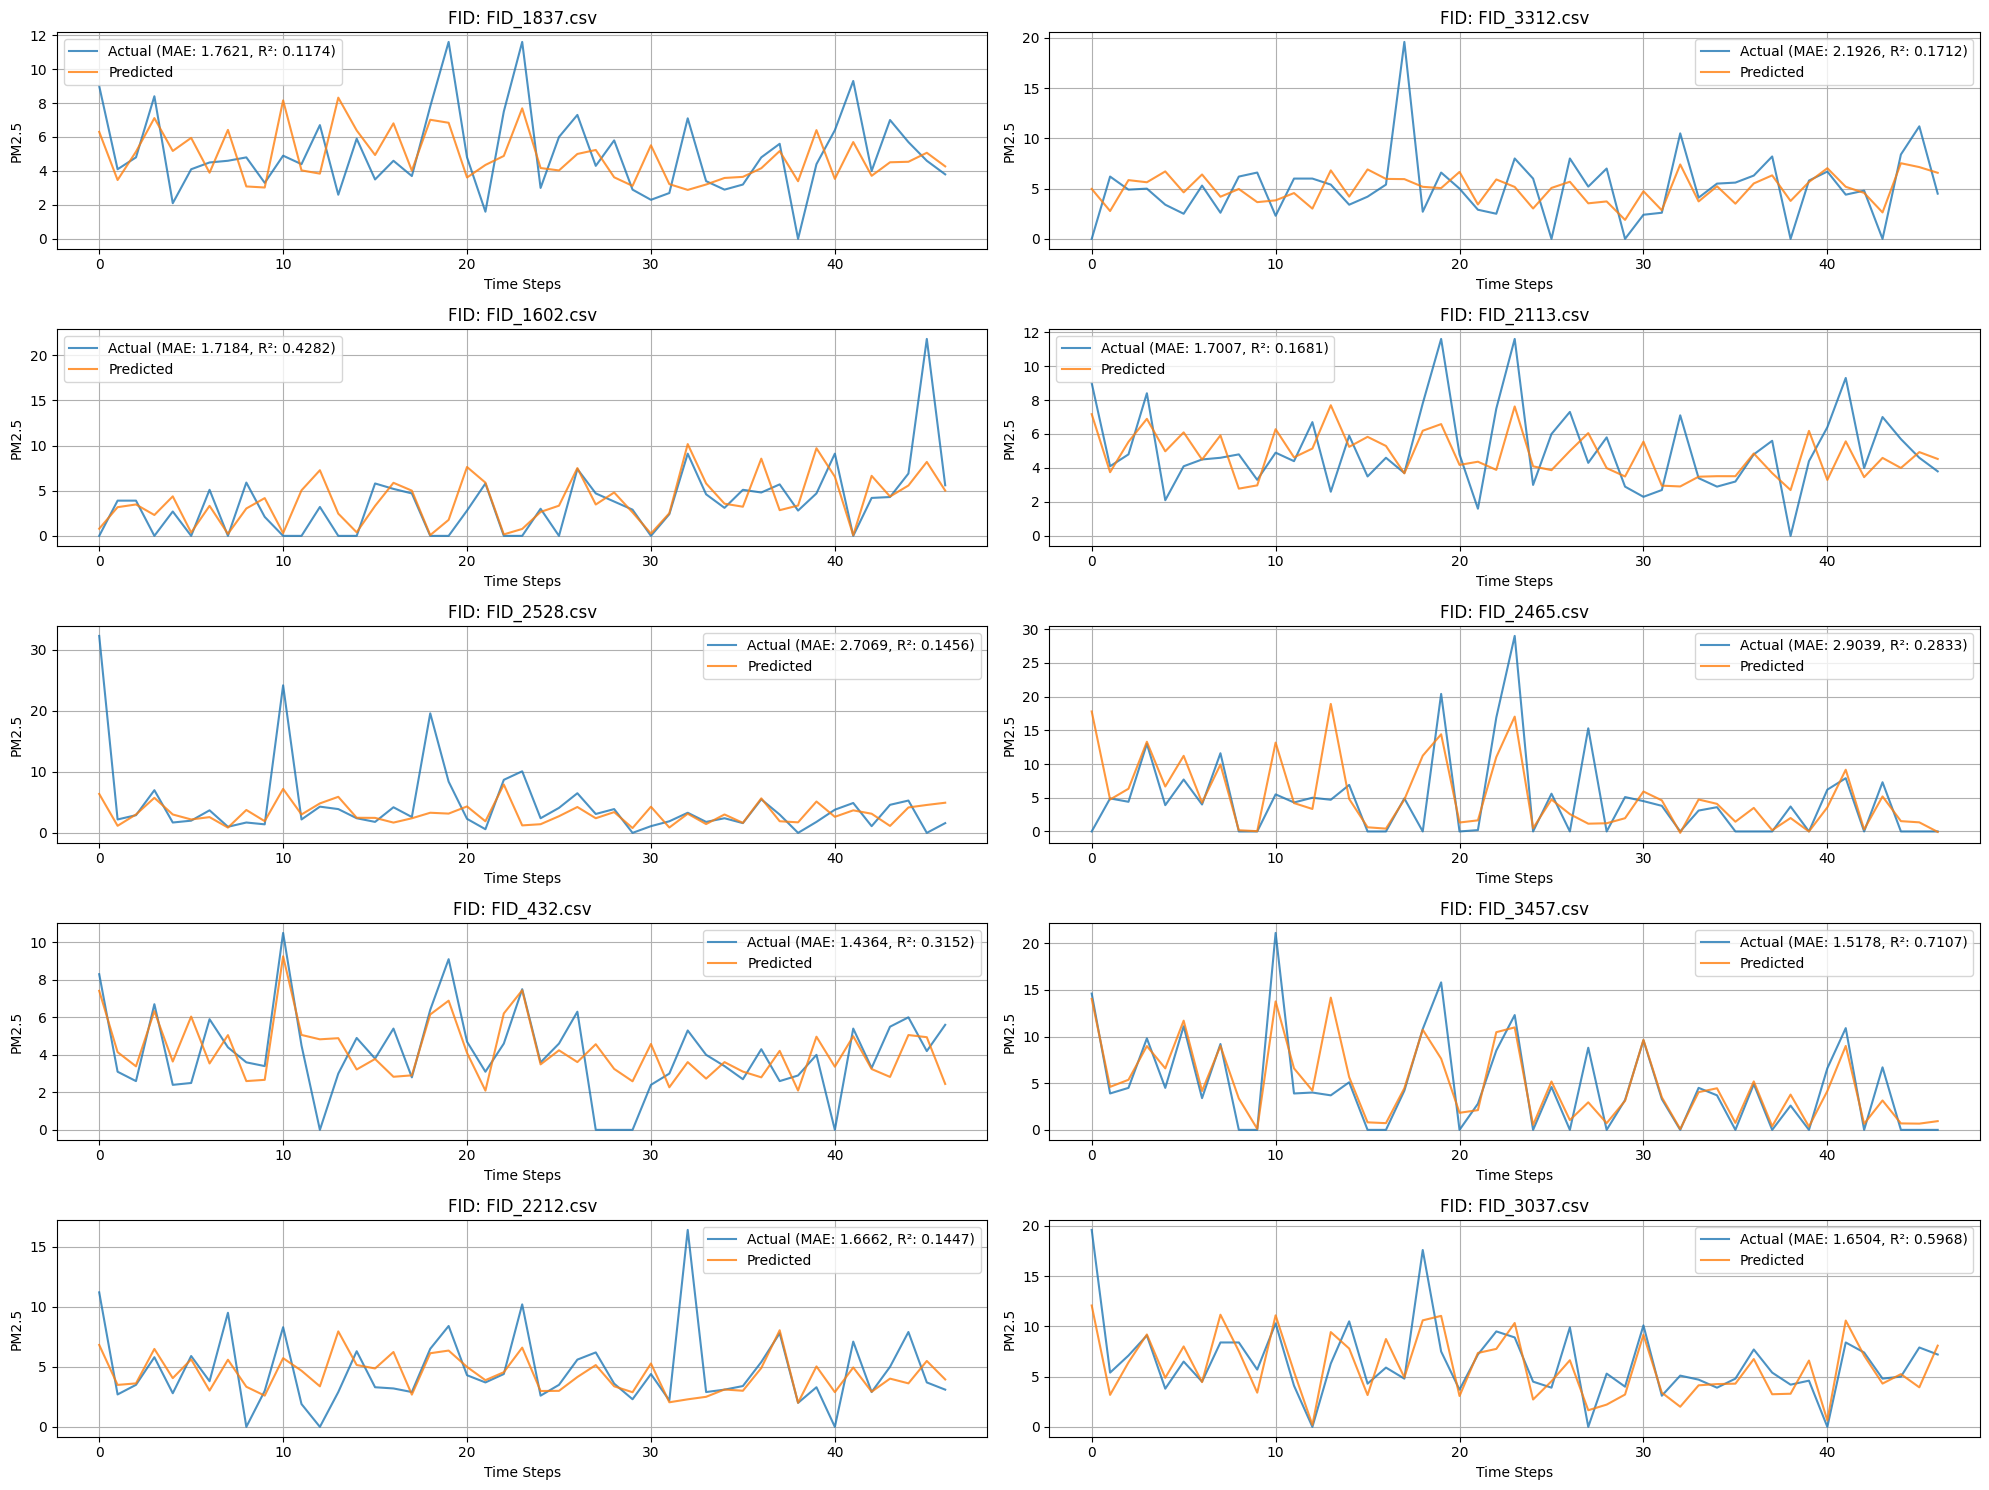


Metrics Summary:
                   MAE      RMSE        R2
FID                                       
FID_1837.csv  1.762122  2.226212  0.117402
FID_3312.csv  2.192589  3.035264  0.171158
FID_1602.csv  1.718402  2.825018  0.428207
FID_2113.csv  1.700681  2.161315  0.168110
FID_2528.csv  2.706854  5.552433  0.145591
FID_2465.csv  2.903947  5.084627  0.283253
FID_432.csv   1.436401  1.863540  0.315225
FID_3457.csv  1.517759  2.655339  0.710660
FID_2212.csv  1.666230  2.823910  0.144673
FID_3037.csv  1.650373  2.287631  0.596768

Average metrics across selected FIDs:
MAE     1.925536
RMSE    3.051529
R2      0.308105
dtype: float64


In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import random
import os

def plot_and_save_fid_predictions(all_fid_data, model, output_dir='fid_predictions',
                                num_fids=10, num_samples=100, figsize=(20, 15)):
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Randomly select FIDs
    selected_fids = random.sample(list(all_fid_data.keys()), min(num_fids, len(all_fid_data)))

    # Create subplots grid
    rows = (num_fids + 1) // 2
    fig, axes = plt.subplots(rows, 2, figsize=figsize)
    axes = axes.flatten()

    # Store metrics for all FIDs
    all_metrics = []

    for idx, fid in enumerate(selected_fids):
        data = all_fid_data[fid]

        # Get predictions
        predictions = model.predict(data['X_test'])

        # Inverse transform predictions and actual values
        predictions_original = data['scaler_y'].inverse_transform(predictions)
        y_test_original = data['scaler_y'].inverse_transform(data['y_test'])

        # Calculate metrics
        metrics = {
            'FID': fid,
            'MAE': mean_absolute_error(y_test_original, predictions_original),
            'RMSE': np.sqrt(mean_squared_error(y_test_original, predictions_original)),
            'R2': r2_score(y_test_original, predictions_original)
        }
        all_metrics.append(metrics)

        # Save predictions to CSV
        results_df = pd.DataFrame({
            'Actual': y_test_original.flatten(),
            'Predicted': predictions_original.flatten()
        })
        csv_path = os.path.join(output_dir, f'fid_{fid}_predictions.csv')
        results_df.to_csv(csv_path, index=True)

        # Plot predictions vs actual
        axes[idx].plot(y_test_original[:num_samples],
                      label=f'Actual (MAE: {metrics["MAE"]:.4f}, R²: {metrics["R2"]:.4f})',
                      alpha=0.8)
        axes[idx].plot(predictions_original[:num_samples],
                      label='Predicted',
                      alpha=0.8)
        axes[idx].set_title(f'FID: {fid}')
        axes[idx].set_xlabel('Time Steps')
        axes[idx].set_ylabel('PM2.5')
        axes[idx].legend()
        axes[idx].grid(True)

    # Remove empty subplots
    for idx in range(len(selected_fids), len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()

    # Save plot
    plot_path = os.path.join(output_dir, 'fid_predictions_plot.png')
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()

    # Save metrics summary
    metrics_df = pd.DataFrame(all_metrics)
    metrics_df = metrics_df.set_index('FID')
    metrics_path = os.path.join(output_dir, 'fid_metrics_summary.csv')
    metrics_df.to_csv(metrics_path)

    # Print summary statistics
    print("\nMetrics Summary:")
    print(metrics_df)
    print("\nAverage metrics across selected FIDs:")
    print(metrics_df.mean())

# Usage
plot_and_save_fid_predictions(all_fid_data, model,
                            output_dir='fid_predictions',
                            num_fids=10,
                            num_samples=100)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


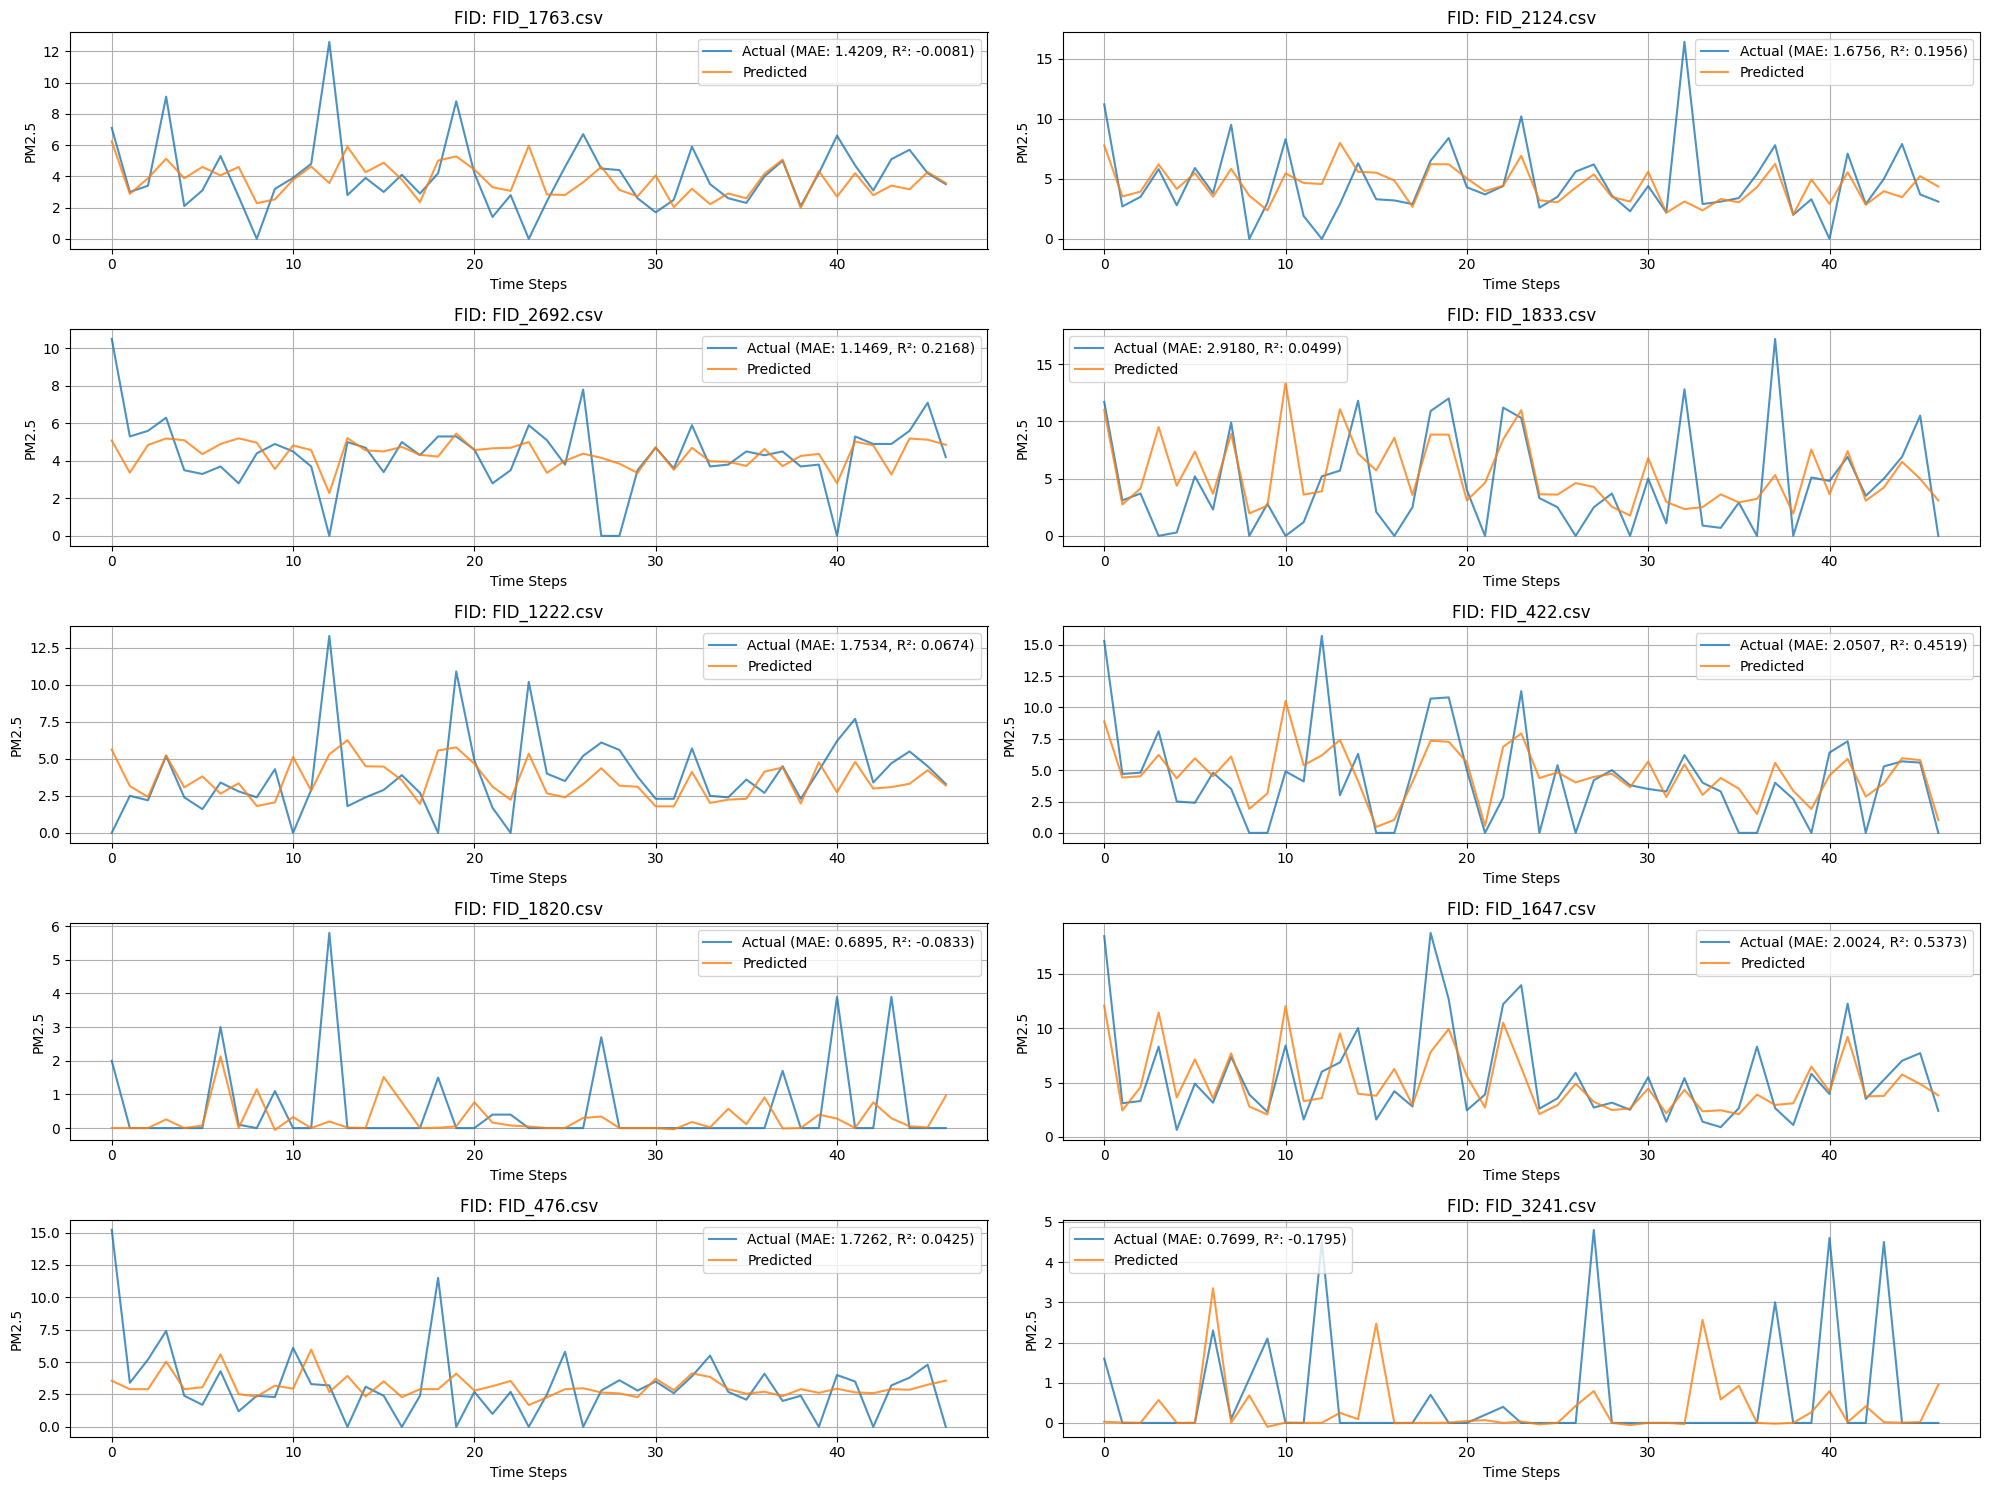


Metrics Summary:
                   MAE      RMSE        R2
FID                                       
FID_1763.csv  1.420928  2.234756 -0.008104
FID_2124.csv  1.675572  2.738628  0.195554
FID_2692.csv  1.146891  1.648740  0.216821
FID_1833.csv  2.918030  4.253707  0.049883
FID_1222.csv  1.753425  2.528494  0.067430
FID_422.csv   2.050745  2.786752  0.451916
FID_1820.csv  0.689527  1.324270 -0.083259
FID_1647.csv  2.002362  2.907298  0.537276
FID_476.csv   1.726210  2.719567  0.042472
FID_3241.csv  0.769862  1.493211 -0.179478

Average metrics across selected FIDs:
MAE     1.615355
RMSE    2.463542
R2      0.129051
dtype: float64


In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import random
import os

def plot_and_save_fid_predictions(all_fid_data, model, original_data_dir, output_dir='fid_predictions1',
                                num_fids=10, num_samples=100, figsize=(20, 15)):
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Randomly select FIDs
    selected_fids = random.sample(list(all_fid_data.keys()), min(num_fids, len(all_fid_data)))

    # Create subplots grid
    rows = (num_fids + 1) // 2
    fig, axes = plt.subplots(rows, 2, figsize=figsize)
    axes = axes.flatten()

    # Store metrics for all FIDs
    all_metrics = []

    for idx, fid in enumerate(selected_fids):
        data = all_fid_data[fid]

        # Get predictions
        predictions = model.predict(data['X_test'])

        # Inverse transform predictions and actual values
        predictions_original = data['scaler_y'].inverse_transform(predictions)
        y_test_original = data['scaler_y'].inverse_transform(data['y_test'])

        # Read original CSV file to get dates
        original_df = pd.read_csv(os.path.join(original_data_dir, fid))

        # Calculate metrics
        metrics = {
            'FID': fid,
            'MAE': mean_absolute_error(y_test_original, predictions_original),
            'RMSE': np.sqrt(mean_squared_error(y_test_original, predictions_original)),
            'R2': r2_score(y_test_original, predictions_original)
        }
        all_metrics.append(metrics)

        # Get the dates corresponding to test set
        sequence_length = data['X_test'].shape[1]  # Get sequence length from data
        test_size = len(y_test_original)

        # Create DataFrame with all available information
        results_df = pd.DataFrame({
            'Date': original_df['date'].iloc[sequence_length:sequence_length + test_size],
            'RH_merra': original_df['RH_merra'].iloc[sequence_length:sequence_length + test_size],
            'aod': original_df['aod'].iloc[sequence_length:sequence_length + test_size],
            'bc': original_df['bc'].iloc[sequence_length:sequence_length + test_size],
            'cmaqPM': original_df['cmaqPM'].iloc[sequence_length:sequence_length + test_size],
            'dustpm': original_df['dustpm'].iloc[sequence_length:sequence_length + test_size],
            'rad_merra': original_df['rad_merra'].iloc[sequence_length:sequence_length + test_size],
            'rain_merra': original_df['rain_merra'].iloc[sequence_length:sequence_length + test_size],
            'temperature': original_df['temperature'].iloc[sequence_length:sequence_length + test_size],
            'wind_merra': original_df['wind_merra'].iloc[sequence_length:sequence_length + test_size],
            'Actual_PM2.5': y_test_original.flatten(),
            'Predicted_PM2.5': predictions_original.flatten()
        })



        # Save to CSV
        csv_path = os.path.join(output_dir, f'fid_{fid}_predictions.csv')
        results_df.to_csv(csv_path, index=False)

        # Plot predictions vs actual
        axes[idx].plot(y_test_original[:num_samples],
                      label=f'Actual (MAE: {metrics["MAE"]:.4f}, R²: {metrics["R2"]:.4f})',
                      alpha=0.8)
        axes[idx].plot(predictions_original[:num_samples],
                      label='Predicted',
                      alpha=0.8)
        axes[idx].set_title(f'FID: {fid}')
        axes[idx].set_xlabel('Time Steps')
        axes[idx].set_ylabel('PM2.5')
        axes[idx].legend()
        axes[idx].grid(True)

    # Remove empty subplots
    for idx in range(len(selected_fids), len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()

    # Save plot
    plot_path = os.path.join(output_dir, 'fid_predictions_plot.png')
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()

    # Save metrics summary
    metrics_df = pd.DataFrame(all_metrics)
    metrics_df = metrics_df.set_index('FID')
    metrics_path = os.path.join(output_dir, 'fid_metrics_summary.csv')
    metrics_df.to_csv(metrics_path)

    # Print summary statistics
    print("\nMetrics Summary:")
    print(metrics_df)
    print("\nAverage metrics across selected FIDs:")
    print(metrics_df.mean())

# Usage
plot_and_save_fid_predictions(all_fid_data, model,
                            original_data_dir="/content/split_files",  # Path to original CSV files
                            output_dir='fid_predictions2',
                            num_fids=10,
                            num_samples=100)